In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_percentage_error

In [2]:
df = pd.read_csv('../_data/ts_dataset.csv')

In [3]:
df.head()

,datetime,rendszerterheles
0,2018-07-02 00:00:00,4191.0
1,2018-07-02 00:15:00,4116.0
2,2018-07-02 00:30:00,4060.0
3,2018-07-02 00:45:00,4025.0
4,2018-07-02 01:00:00,3976.0


In [4]:
df.shape

(106176, 2)

In [5]:
df.describe()

,rendszerterheles
count,106176.000000
mean,5202.597362
std,753.330119
min,3159.000000
25%,4632.000000
50%,5226.000000
75%,5736.000000
max,7119.000000


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106176 entries, 0 to 106175
Data columns (total 2 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   datetime          106176 non-null  object 
 1   rendszerterheles  106176 non-null  float64
dtypes: float64(1), object(1)
memory usage: 1.6+ MB


In [7]:
df['datetime'] = pd.to_datetime(df['datetime'])

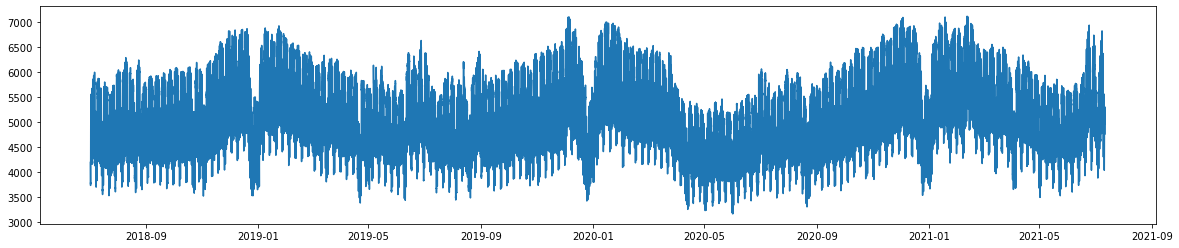

In [8]:
plt.figure(figsize=(20, 4))
plt.plot(df['datetime'], df['rendszerterheles'])

In [9]:
df.loc[(df['datetime']>='2018-10-01')&
       (df['datetime']<'2018-11-01')]

,datetime,rendszerterheles
8736,2018-10-01 00:00:00,4185.0
8737,2018-10-01 00:15:00,4106.0
8738,2018-10-01 00:30:00,4056.0
8739,2018-10-01 00:45:00,3985.0
8740,2018-10-01 01:00:00,3960.0
...,...,...
11707,2018-10-31 22:45:00,5121.0
11708,2018-10-31 23:00:00,5008.0
11709,2018-10-31 23:15:00,4954.0
11710,2018-10-31 23:30:00,4865.0


In [10]:
df.loc[df['datetime']=='2018-10-01']

,datetime,rendszerterheles
8736,2018-10-01,4185.0


<AxesSubplot:xlabel='datetime'>

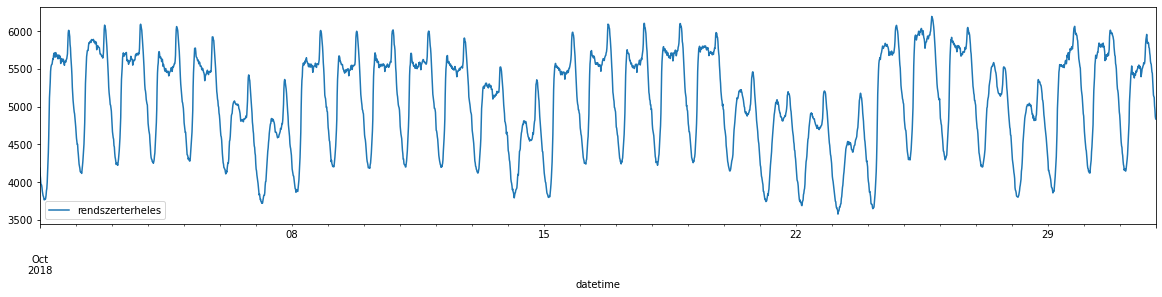

In [11]:
df.set_index('datetime').loc['2018-10', :].plot(figsize=(20, 4))

In [12]:
df['month'] = df['datetime'].dt.month
df['dayofweek'] = df['datetime'].dt.dayofweek
df['time'] = df['datetime'].dt.time
df['date'] = df['datetime'].dt.date

<AxesSubplot:xlabel='dayofweek,time'>

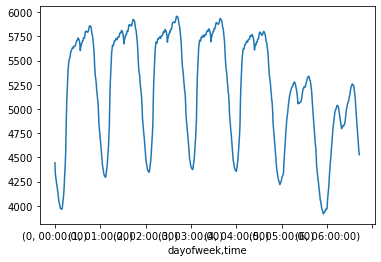

In [13]:
df.groupby(['dayofweek', 'time'])['rendszerterheles'].mean().plot()

<AxesSubplot:xlabel='datetime'>

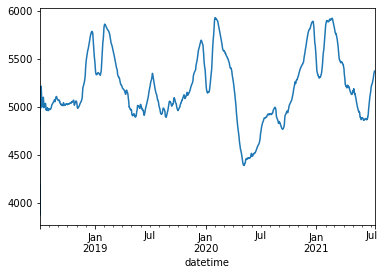

In [14]:
df.set_index('datetime')['rendszerterheles'].rolling('28d').mean().plot()

(0.0, 1000.0)

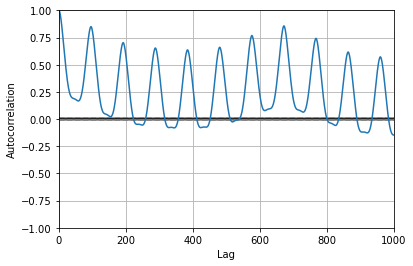

In [15]:
# pd.plotting.autocorrelation_plot(df['rendszerterheles']).set_xlim(0, 1000)

In [16]:
score_list = []
for i in range(96 * 15):
    score = df['rendszerterheles'].autocorr(i)
    score_list.append(score)

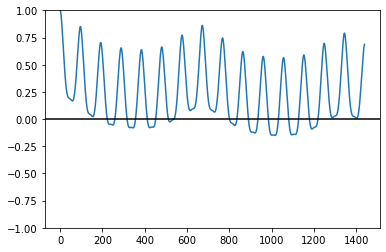

In [17]:
plt.plot(score_list)
plt.ylim(-1, 1)
plt.axhline(0, color='black')

In [18]:
# df['rendszerterheles'].shift(96*2)

In [19]:
df.head(2)

,datetime,rendszerterheles,month,dayofweek,time,date
0,2018-07-02 00:00:00,4191.0,7,0,00:00:00,2018-07-02
1,2018-07-02 00:15:00,4116.0,7,0,00:15:00,2018-07-02


In [20]:
df['datetime_2d'] = df['datetime'] + pd.to_timedelta(-2, unit='day')
df['datetime_7d'] = df['datetime'] + pd.to_timedelta(-7, unit='day')

In [21]:
value_map = df.set_index('datetime')['rendszerterheles']

In [22]:
df['rendszerterheles_2d'] = df['datetime_2d'].map(value_map)
df['rendszerterheles_7d'] = df['datetime_7d'].map(value_map)

In [23]:
df.isnull().sum()

datetime                 0
rendszerterheles         0
month                    0
dayofweek                0
time                     0
date                     0
datetime_2d              0
datetime_7d              0
rendszerterheles_2d    192
rendszerterheles_7d    672
dtype: int64

In [29]:
from workalendar.europe import Hungary

In [30]:
cal = Hungary()

In [36]:
year_list = df['datetime'].dt.year.unique()

In [45]:
holiday_df = pd.DataFrame()

for year in year_list:
    temp_df = \
    pd.DataFrame(cal.holidays(year),
                 columns=['date', 'holiday_name'])
    holiday_df = pd.concat([holiday_df, temp_df], axis=0)

In [48]:
holiday_map = holiday_df.set_index('date')['holiday_name']

In [54]:
df['holiday_name'] = df['date'].map(holiday_map)

In [56]:
df['is_holiday'] = 0
df.loc[df['holiday_name'].notnull(), 'is_holiday'] = 1

In [57]:
df['is_holiday'].value_counts()

0    102432
1      3744
Name: is_holiday, dtype: int64

In [62]:
month_dummies = \
pd.get_dummies(df['month'], drop_first=True, prefix='month')

dayofweek_dummies = \
pd.get_dummies(df['dayofweek'], drop_first=True, prefix='dayofweek')

In [65]:
df = pd.concat([df, month_dummies, dayofweek_dummies], axis=1)

In [69]:
dummy_cols = \
month_dummies.columns.tolist() + dayofweek_dummies.columns.tolist()

In [70]:
X_cols = ['rendszerterheles_2d', 'rendszerterheles_7d',
         'is_holiday'] + dummy_cols

In [71]:
y_col = 'rendszerterheles'

In [78]:
df = df.dropna(subset=['rendszerterheles_2d', 'rendszerterheles_7d'])

In [80]:
df = df.reset_index(drop=True)

In [82]:
X = df.loc[:, X_cols]
y = df.loc[:, y_col]

In [83]:
model = GradientBoostingRegressor(random_state=1)

In [92]:
X_train = X.loc[:80000, :]
X_test = X.loc[80001:, :]
y_train = y.loc[:80000]
y_test = y.loc[80001:]

In [93]:
model.fit(X_train, y_train)

GradientBoostingRegressor(random_state=1)

In [94]:
pred = model.predict(X_test)

In [96]:
mean_absolute_percentage_error(y_test[:96], pred[:96])

0.026814149073630444

In [101]:
mean_absolute_percentage_error(y_test[:96],
                               X_test['rendszerterheles_2d'][:96])

0.09543018915048318

In [102]:
mean_absolute_percentage_error(y_test[:96],
                               X_test['rendszerterheles_7d'][:96])

0.029374774907352446

In [104]:
dates_list = pd.date_range('2021-02-01', '2021-02-03')

In [115]:
model = GradientBoostingRegressor(n_estimators=100, random_state=1)
pred_df = pd.DataFrame()
for date in dates_list:
    df_train = df.loc[df['datetime']<(date + pd.to_timedelta(-1, unit='day'))]
    df_test = df.loc[df['date']==date]
    
    X_train = df_train.loc[:, X_cols]
    X_test = df_test.loc[:, X_cols]
    
    y_train = df_train.loc[:, y_col]
    y_test = df_test.loc[:, y_col]
    
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    
    temp_df = pd.DataFrame()
    temp_df['datetime'] = df_test['datetime']
    temp_df['act'] = y_test
    temp_df['pred'] = pred
    
    pred_df = pd.concat([pred_df, temp_df], axis=0)
pred_df = pred_df.reset_index(drop=True)

In [116]:
mean_absolute_percentage_error(pred_df['act'], pred_df['pred'])

0.030685643731297303

<AxesSubplot:>

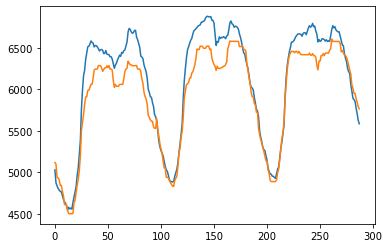

In [119]:
pred_df['act'].plot()
pred_df['pred'].plot()